In [120]:
from sinexpDL import *
from pathlib import Path
runnum = 0

In [121]:
import numpy as np
import math
import sys
import os
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from datetime import date, datetime
cuda = True if torch.cuda.is_available() else False
device = "cuda:0" if cuda else "cpu"
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

class OPT(object):
    def __init__(self,) -> None:
        self.n_epochs = 200
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 1
        self.img_size = 64
        self.channels = 1
        self.img_shape = (1, self.img_size, self.img_size)
opt = OPT()


In [122]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Tanh())
            return layers
        
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img


In [123]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [124]:
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [125]:
# Loss weight for gradient penalty
lambda_gp = 10
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    # print(alpha.shape,real_samples.shape,fake_samples.shape)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [126]:
pstart = 1
pend = 2
ds = specGds("cuda:0", pstart, pend)
dataloader = DataLoader(ds,
    batch_size=opt.batch_size,
    shuffle=True,
    drop_last=False,
)

def noise_fn(x = opt.batch_size):
    return Variable(torch.abs(torch.normal(mean = (pstart+pend)/2, std = (pend - pstart)/8, size = (x,opt.latent_dim),device=device)))


self.pspace.shape = (1000,) | self.__len__() = 1000


In [131]:
noise_fn()

tensor([[1.2749],
        [1.5173],
        [1.4179],
        [1.7979],
        [1.5083],
        [1.6503],
        [1.4887],
        [1.4980],
        [1.4873],
        [1.4741],
        [1.3566],
        [1.3339],
        [1.4950],
        [1.6004],
        [1.3664],
        [1.6646],
        [1.4335],
        [1.4499],
        [1.5366],
        [1.5127],
        [1.6863],
        [1.4747],
        [1.7779],
        [2.0387],
        [1.4958],
        [1.4699],
        [1.6177],
        [1.4969],
        [1.5950],
        [1.3773],
        [1.5648],
        [1.5504],
        [1.3643],
        [1.7023],
        [1.5942],
        [1.2785],
        [1.6205],
        [1.6449],
        [1.8177],
        [1.4590],
        [1.4755],
        [1.3722],
        [1.4485],
        [1.6235],
        [1.2992],
        [1.3833],
        [1.3918],
        [1.5737],
        [1.4129],
        [1.8895],
        [1.3592],
        [1.4550],
        [1.5421],
        [1.2978],
        [1.5169],
        [1

In [130]:
batches_done = 0
timestarted = datetime.now()
timestarted = str(timestarted.hour) + " " + str(timestarted.minute) + " " +  str(timestarted.second)
dloss = []
gloss = []
for epoch in range(opt.n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = noise_fn(imgs.shape[0])

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # -----------------
        #  Train Generator
        # -----------------

        # Generate a batch of images
        fake_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        # Train on fake images
        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()

        print(
            f"[Epoch {epoch}/{opt.n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.5}] [G loss: {g_loss.item():.5}] {' '*5}", flush=True, end = "\r"
        )
        dloss.append(d_loss.item())
        gloss.append(g_loss.item())
        if i%16 == 0:
            print()

        if batches_done % 5 == 0:
            path = Path(f"./images/{date.today()}/{timestarted}/{runnum}/")
            path.mkdir(parents=True, exist_ok=True)
            save_image(fake_imgs.data[:], f"images/{date.today().isoformat()}/{timestarted}/{runnum}/{batches_done}.png", nrow=8, normalize=True)
        
        batches_done += 1

[Epoch 0/200] [Batch 0/16] [D loss: -0.16562] [G loss: 0.14891]      
[Epoch 1/200] [Batch 0/16] [D loss: 0.94202] [G loss: -0.79241]        
[Epoch 2/200] [Batch 0/16] [D loss: 0.8898] [G loss: -0.21785]       
[Epoch 3/200] [Batch 0/16] [D loss: -1.2014] [G loss: 1.116]        
[Epoch 4/200] [Batch 0/16] [D loss: -0.3646] [G loss: 0.22923]        
[Epoch 5/200] [Batch 0/16] [D loss: 2.9663] [G loss: -0.18656]          
[Epoch 6/200] [Batch 0/16] [D loss: 0.78224] [G loss: -0.87613]       
[Epoch 7/200] [Batch 0/16] [D loss: 1.379] [G loss: -0.98574]       
[Epoch 8/200] [Batch 0/16] [D loss: -1.3134] [G loss: 1.2237]         
[Epoch 9/200] [Batch 0/16] [D loss: -0.4239] [G loss: 0.28393]        
[Epoch 10/200] [Batch 0/16] [D loss: 0.98439] [G loss: -0.16558]        
[Epoch 11/200] [Batch 0/16] [D loss: 0.52995] [G loss: -0.6979]        
[Epoch 12/200] [Batch 0/16] [D loss: 1.5588] [G loss: -1.6622]        
[Epoch 13/200] [Batch 0/16] [D loss: 2.8895] [G loss: -2.4734]       
[Epoch 

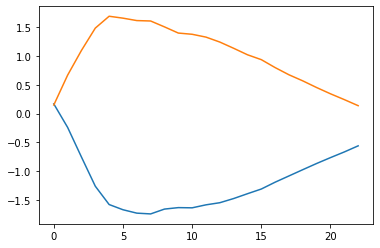

In [ ]:
plt.plot(dloss)
plt.plot(gloss)
plt.show()